In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # Import minor locator ticker
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from re import split

from scipy.optimize import curve_fit

import calendar

# from dask_jobqueue import SLURMCluster

# from dask.distributed import Client, progress
from IPython.display import Image
from dask.distributed import Client
import folium

import warnings

warnings.filterwarnings('ignore')

import seaborn as sns
# import hvplot.xarray

import Functions as Func

In [ ]:
ds_1 = xr.open_zarr(r"E:\Universidad\Trabajo_de_Grado_Isabel\Datos_Solicitados_SIATA_JPC\resultados\Zarr\425_filtrado.zarr")
# pluvio = pd.read_csv(r'E:\Universidad\Trabajo_de_Grado_Isabel\Datos_Solicitados_SIATA_JPC\Pluviometricas_cercanas\Filtradas\Pluviometrica_60.csv', index_col=0, parse_dates=True)

Disdro_name = 'Montañita San Antonio'

In [ ]:
ds_1

In [ ]:
# Condición combinada: menor que 0.1 o mayor que 12
# condicion_invalida = (ds_filtered['lwc_filt'] < 0.1) | (ds_filtered['lwc_filt'] > 12)
condicion_invalida_2 = (ds_1['lwc_filt'] < 0.05) | (ds_1['lwc_filt'] > 13)

# Aplicar la máscara
ds_1['lwc_filt'] = ds_1['lwc_filt'].where(~condicion_invalida_2, np.nan)

# Asegúrate de usar .compute() si estás usando Dask
dm = ds_1.d_m_filt
nw = ds_1.n_w_filt

dm_comp = dm.compute() if hasattr(dm, 'compute') else dm
nw_comp = nw.compute() if hasattr(nw, 'compute') else nw

# Crear la máscara de outliers
mask_outlier = (dm_comp > 6.5) & (np.log10(nw_comp) > 2)

# Reemplazar en el Dataset original usando .where
ds_1['d_m_filt'] = ds_1['d_m_filt'].where(~mask_outlier, np.nan)
ds_1['n_w_filt'] = ds_1['n_w_filt'].where(~mask_outlier, np.nan)

In [ ]:
# Crear figura con dos subgráficas (verticales)
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=False)

# --- Subgráfico 1: Histograma de D_0 ---
sns.histplot(ds_1.d_m_filt, bins=22, stat="probability", ax=axs[0], color='tab:blue', label='$D_0\ [mm]$')
axs[0].set_title(f'{Disdro_name}')
axs[0].set_ylabel('PDF', color='tab:blue')
axs[0].tick_params(axis='y', labelcolor='tab:blue')
axs[0].set_xlim(0, 5.5)
axs[0].set_xticks(np.arange(0, 5.5, 0.5))
axs[0].legend(loc='upper left')

# Crear eje gemelo para n_w_filt
ax2 = axs[0].twinx()

# Histograma de n_w_filt con eje derecho
sns.histplot(np.log10(ds_1.n_w_filt), bins=22, stat="probability", ax=ax2, label='$log_{10}(N_w)\ [mm^{-1}m^{-3}]$', color='tab:red', alpha=0.6)
ax2.set_ylabel('PDF', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax2.legend(loc='upper right')

# Mostrar leyenda y gráfico
fig.tight_layout()

# --- Subgráfico 2: Histograma de Nw ---
sns.histplot(ds_1.lwc_filt, bins=15, ax=axs[1], color='tab:red', label='$LWC\ [g/m^3]$')
# axs[1].set_title('Distribución de $N_w$')
# axs[1].set_xlabel('$N_w\ [mm^{-3} mm^{-1}]$')
axs[1].set_ylabel('')
axs[1].set_yscale('log')
# axs[1].set_xticks(np.arange(0, 5.5, 0.5))
axs[1].legend()

# Ajustar espacios
plt.tight_layout()

plt.show()

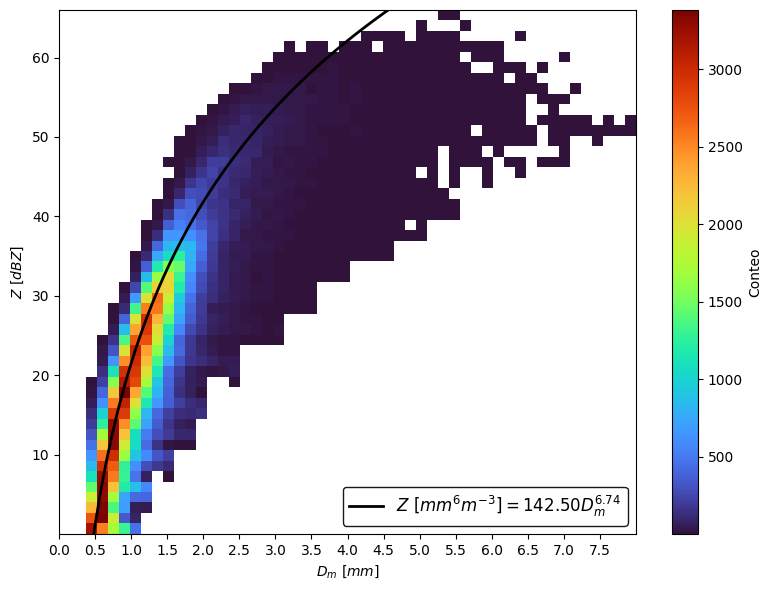

In [59]:
def power_law(dm):
    return 142.50 * dm ** 6.74

# Curva ajustada
dm_range = np.linspace(0.1, 8, 100)
z_model = power_law(dm_range)

ref_data = 10 * np.log10(ds_1.ref_filt)

ref_model = 10 * np.log10(z_model)

mask = ((~np.isnan(ds_1.d_m_filt)) & (~np.isnan(ref_data)) & (ref_data > 0)).compute()

# Aplicar la máscara
dm = ds_1.d_m_filt.where(mask, drop=True)
z_dbz = ref_data.where(mask, drop=True)

# Crear el histograma 2D (heatmap de conteo)
plt.figure(figsize=(8, 6))
hb = plt.hist2d(dm, z_dbz, bins=[50, 50], cmap='turbo', cmin=1)

plt.plot(dm_range, ref_model, color='black', linestyle='-', label='$Z\ [mm^6m^{-3}]=142.50 D_m^{6.74}$', linewidth=2)

# Añadir barra de color
cb = plt.colorbar(hb[3])
cb.set_label('Conteo')

# Etiquetas y título
plt.xlabel('$D_m\ [mm]$')
plt.ylabel('$Z\ [dBZ]$')
# plt.title('Reflectividad vs Diámetro medio')

# Opcional: ajustar límites de ejes
plt.xlim(0, 8)
plt.xticks(np.arange(0, 8, 0.5))
# plt.ylim(10, 60)
plt.legend(
    loc='lower right',
    fontsize=12,
    frameon=True,         # para que tenga recuadro
    framealpha=0.9,       # transparencia del recuadro
    edgecolor='black'     # color del borde
)

plt.tight_layout()
plt.show()

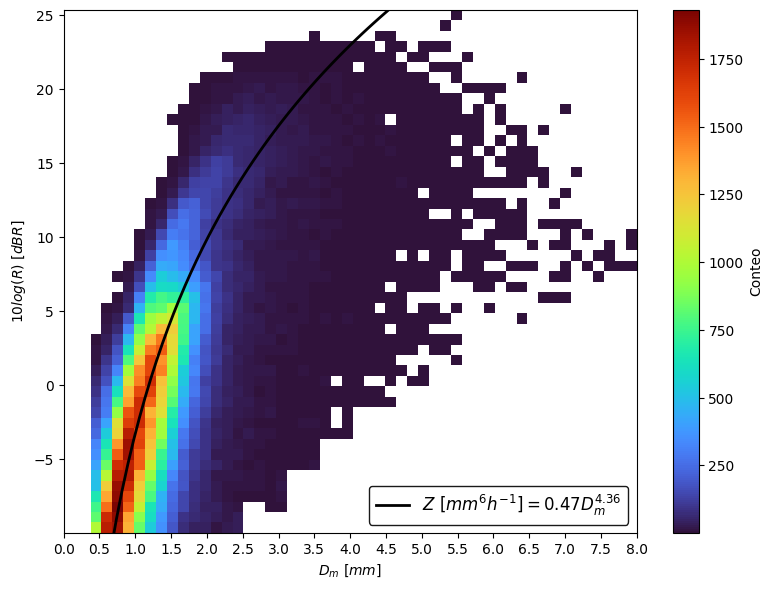

In [60]:
def power_law(dm):
    return 0.47 * dm ** 4.36

# Curva ajustada
dm_range = np.linspace(0.1, 8, 100)
r_model = power_law(dm_range)

rain_model = 10 * np.log10(r_model)

# Convertir R (intensidad de lluvia) a escala logarítmica
r_dbr = 10 * np.log10(ds_1.r_int_filt)

# Crear máscara válida: sin NaNs y solo R > 0
mask = (
    (~np.isnan(ds_1.d_m_filt)) &
    (~np.isnan(r_dbr)) &
    (ds_1.r_int_filt > 0) &
    (r_dbr > -10)
).compute()

# Aplicar máscara
dm = ds_1.d_m_filt.where(mask, drop=True)
r_dbr = r_dbr.where(mask, drop=True)

# Crear histograma 2D: Dm vs dBR
plt.figure(figsize=(8, 6))
hb = plt.hist2d(dm, r_dbr, bins=[50, 50], cmap='turbo', cmin=1)

plt.plot(dm_range, rain_model, color='black', linestyle='-', label='$Z\ [mm^6h^{-1}]=0.47 D_m^{4.36}$', linewidth=2)

# Barra de color (conteo)
cb = plt.colorbar(hb[3])
cb.set_label('Conteo')

# Etiquetas y título
plt.xlabel('$D_m\ [mm]$')
plt.ylabel('$10log(R)\ [dBR]$')
# plt.title('Relación $D_m$ vs $R$')

# Ajustes de ejes
plt.xlim(0, 8)
plt.xticks(np.arange(0, 8.5, 0.5))
# plt.ylim(0, 60)  # puedes personalizar según rango de tus datos
plt.legend(
    loc='lower right',
    fontsize=12,
    frameon=True,         # para que tenga recuadro
    framealpha=0.9,       # transparencia del recuadro
    edgecolor='black'     # color del borde
)

plt.tight_layout()
plt.show()

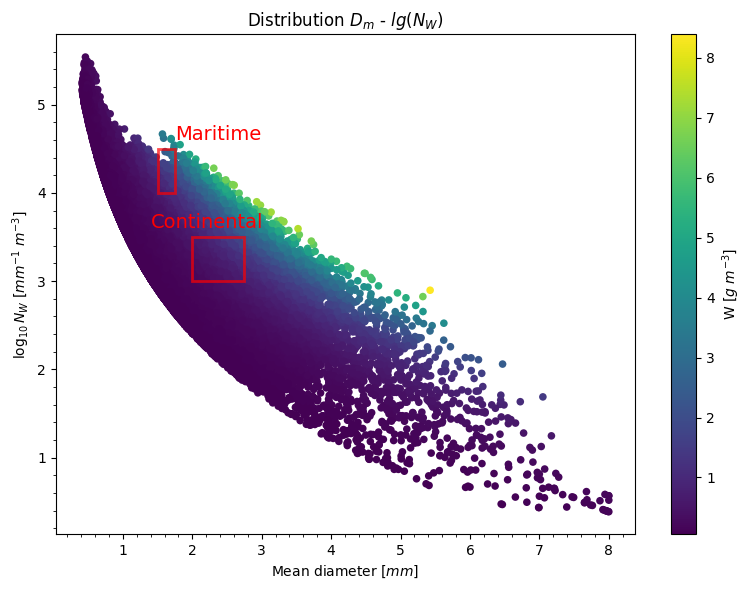

In [55]:
# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar el scatter como mapa de calor
sc = ax.scatter(
    ds_1.d_m_filt,
    np.log10(ds_1.n_w_filt),
    c=ds_1.lwc_filt,
    cmap='viridis', 
    norm=mcolors.Normalize(),  # o usa LogNorm() si W_filt varía logarítmicamente
    s=30,  # tamaño de los puntos
    edgecolors='none'
)

# --- Rectángulo 1: D_m entre 1.5 y 1.75, log10(N_w) entre 4 y 4.5 ---
rect1 = patches.Rectangle(
    (1.5, 4),          # esquina inferior izquierda (x, y)
    width=0.25,        # 1.75 - 1.5
    height=0.5,        # 4.5 - 4
    linewidth=2,
    edgecolor='red',
    facecolor='none',
    alpha=0.7,
    linestyle='-'
)

# --- Rectángulo 2: D_m entre 2 y 2.75, log10(N_w) entre 3 y 3.5 ---
rect2 = patches.Rectangle(
    (2, 3),
    width=0.75,
    height=0.5,
    linewidth=2,
    edgecolor='red',
    facecolor='none',
    alpha=0.7,
    linestyle='-'
)

# Añadir los rectángulos
ax = plt.gca()
ax.add_patch(rect1)
ax.add_patch(rect2)

# Etiquetas
ax.set_xlabel('Mean diameter $[mm]$')
ax.set_ylabel('$\log_{10}N_W\ [mm^{-1}\ m^{-3}]$')
ax.set_title('Distribution $D_m$ - $lg(N_W)$')

plt.text(1.4, 3.6, 'Continental', fontsize=14, color='red')
plt.text(1.75, 4.6, 'Maritime', fontsize=14, color='red')

# Barra de color
cbar = plt.colorbar(sc, ax=ax, label='W $[g\ m^{-3}]$')  # Ajusta unidad si es otra

# Ajustes de diseño
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.tight_layout()
plt.show()

In [57]:
ds_1.to_zarr(r"E:\Universidad\Trabajo_de_Grado_Isabel\Datos_Solicitados_SIATA_JPC\resultados\Zarr\425_filtrado_plot.zarr")

alpha = 142.53, beta = 6.74


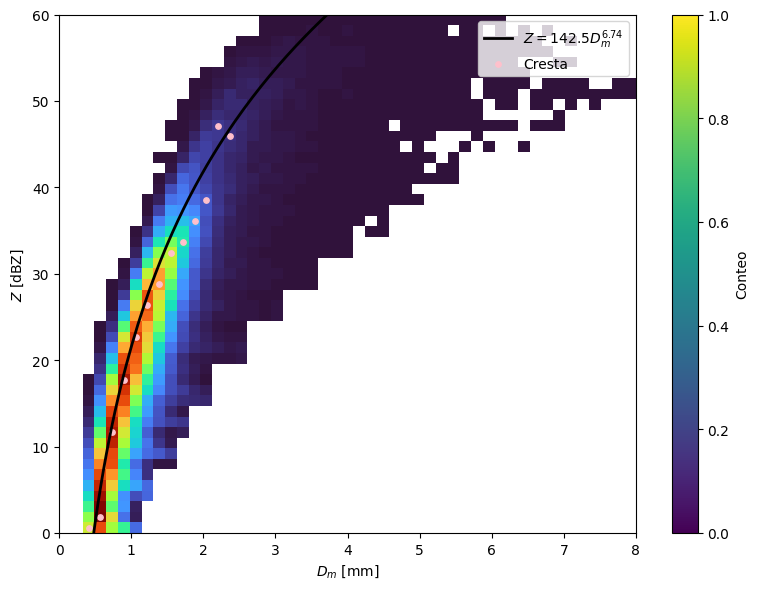

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- 1. Preparar datos ---
ref_data = 10 * np.log10(ds_1.ref_filt)

# Máscara de datos válidos
mask = ((~np.isnan(ds_1.d_m_filt)) & (~np.isnan(ref_data)) & (ref_data > 0)).compute()
dm = ds_1.d_m_filt.where(mask, drop=True).values
z_dbz = ref_data.where(mask, drop=True).values

# --- 2. Construir histograma 2D ---
bins_dm = np.linspace(0, 8, 50)
bins_z  = np.linspace(0, 60, 50)
H, xedges, yedges = np.histogram2d(dm, z_dbz, bins=[bins_dm, bins_z])

# --- 3. Encontrar la cresta con filtrado ---
min_count = 2000  # número mínimo de puntos por bin para incluirlo
crest_dm = []
crest_z  = []

for i in range(len(xedges)-1):
    col = H[i, :]
    total_count = np.sum(col)
    if total_count >= min_count:  # solo bins con suficiente conteo
        j_max = np.argmax(col)
        dm_center = 0.5 * (xedges[i] + xedges[i+1])
        z_center  = 0.5 * (yedges[j_max] + yedges[j_max+1])
        crest_dm.append(dm_center)
        crest_z.append(z_center)

crest_dm = np.array(crest_dm)
crest_z = np.array(crest_z)

# --- 4. Pasar Z_dBZ a Z lineal ---
crest_z_lin = 10 ** (crest_z / 10)

# --- 5. Ajuste del modelo ---
def power_law(Dm, alpha, beta):
    return alpha * Dm**beta

popt, pcov = curve_fit(power_law, crest_dm, crest_z_lin, p0=[200, 5])
alpha_fit, beta_fit = popt
print(f"alpha = {alpha_fit:.2f}, beta = {beta_fit:.2f}")

# --- 6. Curva ajustada ---
dm_range = np.linspace(0.1, 8, 200)
z_fit_lin = power_law(dm_range, alpha_fit, beta_fit)
z_fit_dbz = 10 * np.log10(z_fit_lin)

# --- 7. Graficar ---
plt.figure(figsize=(8, 6))
plt.hist2d(dm, z_dbz, bins=[bins_dm, bins_z], cmap='turbo', cmin=1)
plt.plot(dm_range, z_fit_dbz, 'k-', linewidth=2,
         label=f'$Z = {alpha_fit:.1f} D_m^{{{beta_fit:.2f}}}$')
plt.scatter(crest_dm, crest_z, color='pink', s=15, label='Cresta')

cb = plt.colorbar()
cb.set_label('Conteo')

plt.xlabel('$D_m$ [mm]')
plt.ylabel('$Z$ [dBZ]')
plt.legend()
plt.tight_layout()
plt.show()

alpha = 0.471, beta = 4.363


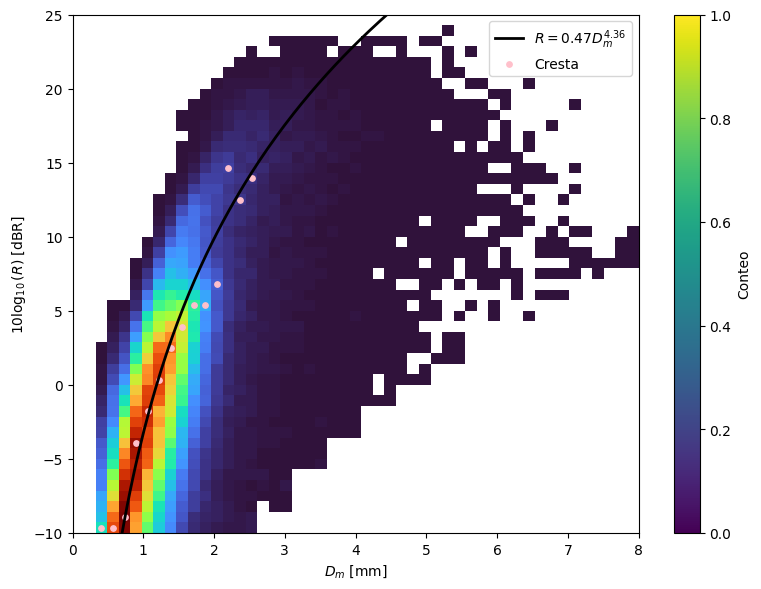

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- 1. Preparar datos ---
r_dbr = 10 * np.log10(ds_1.r_int_filt)

# Máscara de datos válidos
mask = (
    (~np.isnan(ds_1.d_m_filt)) &
    (~np.isnan(r_dbr)) &
    (r_dbr > -10)
).compute()

dm = ds_1.d_m_filt.where(mask, drop=True).values
r_dbr = r_dbr.where(mask, drop=True).values

# --- 2. Construir histograma 2D ---
bins_dm = np.linspace(0, 8, 50)
bins_r  = np.linspace(-10, 25, 50)  # rango para R en dBR
H, xedges, yedges = np.histogram2d(dm, r_dbr, bins=[bins_dm, bins_r])

# --- 3. Encontrar la cresta ---
min_count = 1300
crest_dm = []
crest_r  = []

for i in range(len(xedges)-1):
    col = H[i, :]
    total_count = np.sum(col)
    if total_count >= min_count:
        j_max = np.argmax(col)
        dm_center = 0.5 * (xedges[i] + xedges[i+1])
        r_center  = 0.5 * (yedges[j_max] + yedges[j_max+1])
        crest_dm.append(dm_center)
        crest_r.append(r_center)

crest_dm = np.array(crest_dm)
crest_r = np.array(crest_r)

# --- 4. Pasar R_dBR a R lineal ---
crest_r_lin = 10 ** (crest_r / 10)

# --- 5. Ajuste del modelo ---
def power_law(Dm, alpha, beta):
    return alpha * Dm**beta

popt, pcov = curve_fit(power_law, crest_dm, crest_r_lin, p0=[1, 1])
alpha_fit, beta_fit = popt
print(f"alpha = {alpha_fit:.3f}, beta = {beta_fit:.3f}")

# --- 6. Curva ajustada ---
dm_range = np.linspace(0.1, 8, 200)
r_fit_lin = power_law(dm_range, alpha_fit, beta_fit)
r_fit_dbr = 10 * np.log10(r_fit_lin)

# --- 7. Graficar ---
plt.figure(figsize=(8, 6))
plt.hist2d(dm, r_dbr, bins=[bins_dm, bins_r], cmap='turbo', cmin=1)
plt.plot(dm_range, r_fit_dbr, 'k-', linewidth=2,
         label=f'$R = {alpha_fit:.2f} D_m^{{{beta_fit:.2f}}}$')
plt.scatter(crest_dm, crest_r, color='pink', s=15, label='Cresta')

cb = plt.colorbar()
cb.set_label('Conteo')

plt.xlabel('$D_m$ [mm]')
plt.ylabel('$10 \log_{10}(R)$ [dBR]')
plt.legend()
plt.tight_layout()
plt.show()

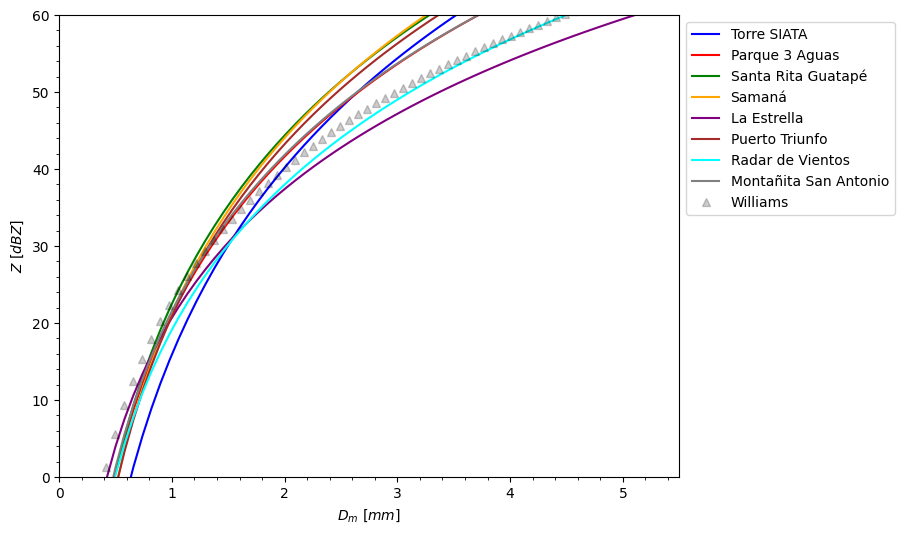

In [13]:
def power_law(dm, a, b):
    return a * dm ** b

dm_range = np.linspace(0.1, 8, 100)

Torre_SIATA = power_law(dm_range, 39, 8.06)
P_3_Aguas = power_law(dm_range, 128.1, 6.82)
S_Rita_Guatape = power_law(dm_range, 177.6, 7.26)
Samana = power_law(dm_range, 136.2, 7.54)
La_Estrella = power_law(dm_range, 116.9, 5.55)
Puerto_Triunfo = power_law(dm_range, 122.6, 7.42)
Radar_Vientos = power_law(dm_range, 81.8, 6.26)
Montañita_SanAntonio = power_law(dm_range, 142.5, 6.74)
Williams = power_law(dm_range, 194, 5.71)

Torre_SIATA_model = 10 * np.log10(Torre_SIATA)
P_3_Aguas_model = 10 * np.log10(P_3_Aguas)
S_Rita_Guatape_model = 10 * np.log10(S_Rita_Guatape)
Samana_model = 10 * np.log10(Samana)
La_Estrella_model = 10 * np.log10(La_Estrella)
Puerto_Triunfo_model = 10 * np.log10(Puerto_Triunfo)
Radar_Vientos_model = 10 * np.log10(Radar_Vientos)
Montañita_SanAntonio_model = 10 * np.log10(Montañita_SanAntonio)
Williams_model = 10 * np.log10(Williams)

plt.figure(figsize=(8, 6))

plt.plot(dm_range, Torre_SIATA_model, label='Torre SIATA', color='blue')
plt.plot(dm_range, P_3_Aguas_model, label='Parque 3 Aguas', color='red')
plt.plot(dm_range, S_Rita_Guatape_model, label='Santa Rita Guatapé', color='green')
plt.plot(dm_range, Samana_model, label='Samaná', color='orange')
plt.plot(dm_range, La_Estrella_model, label='La Estrella', color='purple')
plt.plot(dm_range, Puerto_Triunfo_model, label='Puerto Triunfo', color='brown')
plt.plot(dm_range, Radar_Vientos_model, label='Radar de Vientos', color='cyan')
plt.plot(dm_range, Montañita_SanAntonio_model, label='Montañita San Antonio', color='gray')
plt.plot(dm_range, Williams_model, '^', label='Williams', color='black', alpha=0.2)

plt.xlabel('$D_m\ [mm]$')
plt.ylabel('$Z\ [dBZ]$')
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(0, 60)
plt.xlim(0, 5.5)

plt.show()

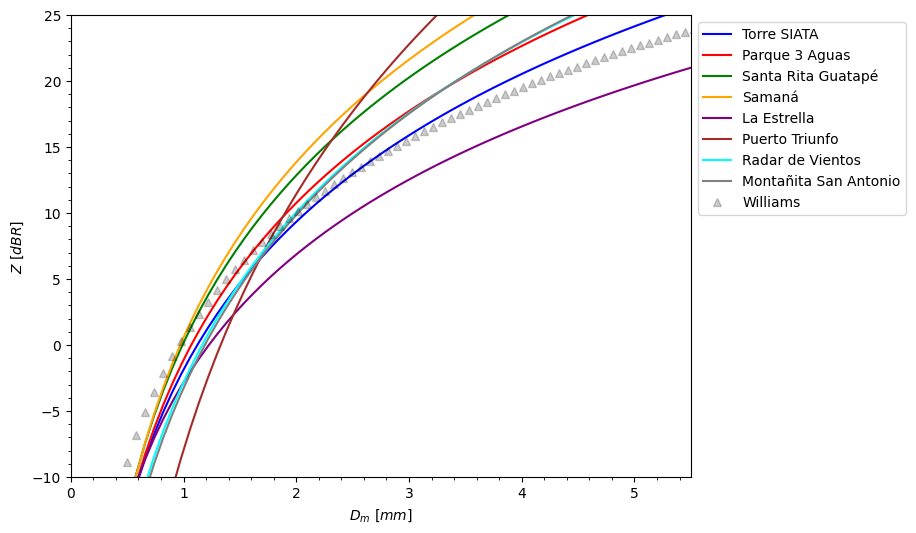

In [14]:
def power_law(dm, a, b):
    return a * dm ** b

dm_range = np.linspace(0.1, 8, 100)

Torre_SIATA = power_law(dm_range, 0.65, 3.72)
P_3_Aguas = power_law(dm_range, 0.77, 3.95)
S_Rita_Guatape = power_law(dm_range, 1.04, 4.21)
Samana = power_law(dm_range, 1.14, 4.41)
La_Estrella = power_law(dm_range, 0.52, 3.22)
Puerto_Triunfo = power_law(dm_range, 0.16, 6.44)
Radar_Vientos = power_law(dm_range, 0.52, 4.28)
Montañita_SanAntonio = power_law(dm_range, 0.47, 4.36)
Williams = power_law(dm_range, 1.15, 3.14)

Torre_SIATA_model = 10 * np.log10(Torre_SIATA)
P_3_Aguas_model = 10 * np.log10(P_3_Aguas)
S_Rita_Guatape_model = 10 * np.log10(S_Rita_Guatape)
Samana_model = 10 * np.log10(Samana)
La_Estrella_model = 10 * np.log10(La_Estrella)
Puerto_Triunfo_model = 10 * np.log10(Puerto_Triunfo)
Radar_Vientos_model = 10 * np.log10(Radar_Vientos)
Montañita_SanAntonio_model = 10 * np.log10(Montañita_SanAntonio)
Williams_model = 10 * np.log10(Williams)

plt.figure(figsize=(8, 6))

plt.plot(dm_range, Torre_SIATA_model, label='Torre SIATA', color='blue')
plt.plot(dm_range, P_3_Aguas_model, label='Parque 3 Aguas', color='red')
plt.plot(dm_range, S_Rita_Guatape_model, label='Santa Rita Guatapé', color='green')
plt.plot(dm_range, Samana_model, label='Samaná', color='orange')
plt.plot(dm_range, La_Estrella_model, label='La Estrella', color='purple')
plt.plot(dm_range, Puerto_Triunfo_model, label='Puerto Triunfo', color='brown')
plt.plot(dm_range, Radar_Vientos_model, label='Radar de Vientos', color='cyan')
plt.plot(dm_range, Montañita_SanAntonio_model, label='Montañita San Antonio', color='gray')
plt.plot(dm_range, Williams_model, '^', label='Williams', color='black', alpha=0.2)

plt.xlabel('$D_m\ [mm]$')
plt.ylabel('$Z\ [dBR]$')
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(-10, 25)
plt.xlim(0, 5.5)

plt.show()